# Topographic Data

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import osmnx.plot as ox_plot
import xarray as xr
import xrspatial

import py3dep
import pydaymet as daymet
from pynhd import NLDI

Py3DEP provides access to the [3DEP](https://www.usgs.gov/core-science-systems/ngp/3dep) database which is a part of the [National Map services](https://viewer.nationalmap.gov/services). The 3DEP service has multi-resolution sources and depending on the user provided resolution, the data is resampled on the server-side based on all the available data sources. 

The following functionalities are currently available:

- `get_map`: Get topographic data the dynamic 3DEP service that supports the following
  layers:

    - DEM
    - Hillshade Gray
    - Aspect Degrees
    - Aspect Map
    - GreyHillshade Elevation Fill
    - Hillshade Multidirectional
    - Slope Degrees
    - Slope Map
    - Hillshade Elevation Tinted
    - Height Ellipsoidal
    - Contour 25
    - Contour Smoothed 25
- `get_dem`: Get DEM data from either the dynamic or static 3DEP service. Considering
  that the static service is much faster, if the target DEM resolution is 10 m, 30 m, or
  60 m, then the static service is used. Otherwise, the dynamic service is used.
- `static_3dep_dem`: Get DEM data at 10 m, 30 m, or 60 m resolution from the staged 3DEP
  data. Since this function only returns DEM, for computing other terrain attributes you
  can use [xarray-spatial](https://xarray-spatial.org). Just note that you should
  reproject the output `DataArray` to a projected CRS like 5070 before passing it to
  `xarray-spatial` like so: `dem = dem.rio.reproject(5070)`.
- `elevation_bygrid`: For retrieving elevations of all the grid points in a 2D grid.
- `elevation_bycoords`: For retrieving elevation of a list of `x` and `y` coordinates.
- `elevation_profile`: For retrieving elevation profile along a line at a given spacing.
  This function converts the line to a B-spline and then calculates the elevation along
  the spline at a given uniform spacing.
- `deg2mpm`: For converting slope dataset from degree to meter per meter.
- `query_3dep_sources`: For querying bounds of 3DEP's data sources within a bounding box.
- `check_3dep_availability`: For querying 3DEP's resolution availability within a bounding box.

Let's get a watershed geometry using NLDI and then get DEM and slope at 90 m resolution.

In [7]:
geometry = NLDI().get_basins(23763529,fsource='comid').geometry[0]

We can get help on the `get_basins` method to see what inputs it takes:

In [ ]:
help(NLDI().get_basins)

We can either directly use `get_map` to get DEM and slope or use `get_dem` to get DEM and then use `xarray-spatial` to compute slope.

In [8]:
topo = py3dep.get_map(["DEM", "Slope Degrees"], geometry, 90, geo_crs=4326, crs=5070)

In [9]:
dem = py3dep.get_dem(geometry, 30)
dem = dem.rio.reproject(5070)
slope = py3dep.deg2mpm(xrspatial.slope(dem))
topo = xr.merge([dem, slope])

What do we have in the topo object?

In [10]:
topo

<xarray.Dataset>
Dimensions:      (x: 3258, y: 2505)
Coordinates:
  * x            (x) float64 -2.136e+06 -2.136e+06 ... -2.059e+06 -2.059e+06
  * y            (y) float64 2.706e+06 2.706e+06 ... 2.646e+06 2.646e+06
    band         int32 1
    spatial_ref  int32 0
Data variables:
    elevation    (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    slope        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        3646.8061523438
    STATISTICS_MEAN:           471.43747096987
    STATISTICS_MINIMUM:        -8.4350395202637
    STATISTICS_STDDEV:         571.85377663773
    STATISTICS_VALID_PERCENT:  11.02
    scale_factor:              1.0
    add_offset:                0.0
    units:                     meters
    vertical_datum:            NAVD88
    vertical_resolution:       0.001
    _FillValue:                nan

We can save the DEM `DataArray` as a raster file using `rioxarray`:

In [11]:
dem.rio.to_raster(Path("input_data", "dem_11092450.tif"))

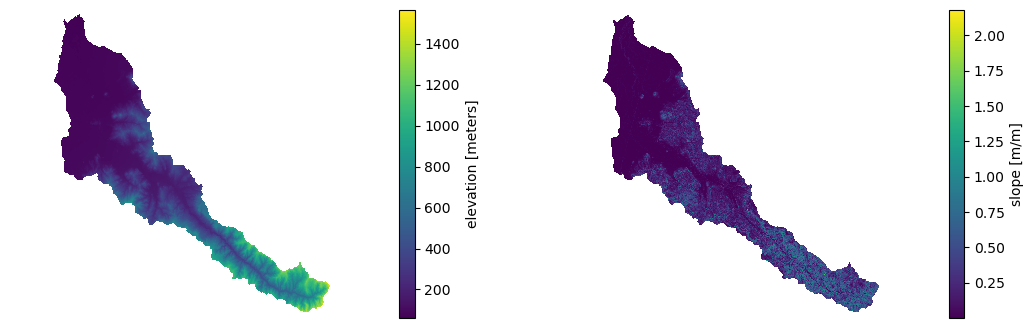

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(13, 4))
dem.plot(ax=axs[0])
slope.plot(ax=axs[1])
for ax in axs:
    ax.set_title("")
    ax.set_axis_off()
fig.savefig("img/dem_slope.png", bbox_inches="tight", facecolor="w")

We can also get elevations of a list of coordinates using `py3dep.elevation_bycoords` function. This function is particularly useful for getting elevations of nodes of a network, for example, is a river or a street network. Let's use [osmnx](https://github.com/gboeing/osmnx) package to get a street network:

In [13]:
G = ox.graph_from_place("Corvallis, OR, USA", network_type="drive")

Now, we can get the elevations for each node based on their coordinates and then plot the results.

In [14]:
x, y = nx.get_node_attributes(G, "x").values(), nx.get_node_attributes(G, "y").values()
elevation = py3dep.elevation_bycoords(list(zip(x, y)), crs="epsg:4326", source="airmap")
nx.set_node_attributes(G, dict(zip(G.nodes(), elevation)), "elevation")

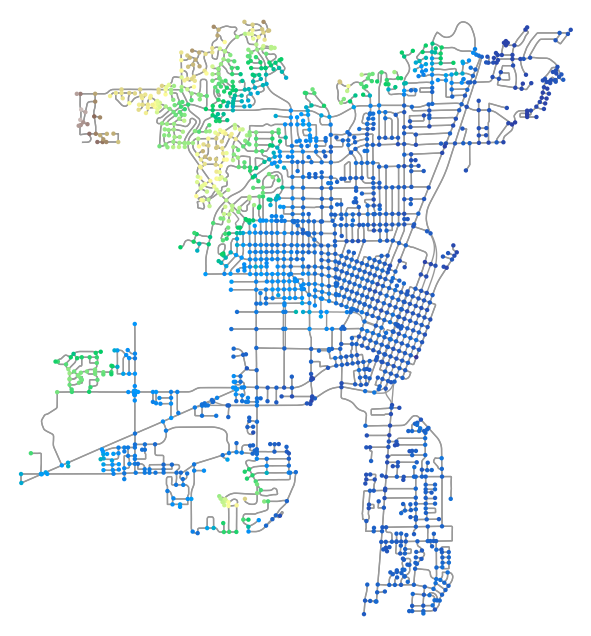

In [15]:
nc = ox_plot.get_node_colors_by_attr(G, "elevation", cmap="terrain")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=10,
    save=True,
    bgcolor="w",
    filepath="_static/street_elev.png",
    dpi=100,
)

Note that, this function gets the elevation data from the elevation map of the bounding box of all the coordinates. So, if the larger the extent of this bounding box, the longer is going to take for the function to get the data.

Additionally, we can get the elevations of set of x- and y- coordinates of a grid. For example,
let's get the minimum temperature data within the watershed from Daymet using [PyDaymet](https://github.com/cheginit/pydaymet) then add the elevation as a new variable to the dataset:

In [16]:
clm = daymet.get_bygeom(geometry, ("2005-01-01", "2005-01-31"), variables="tmin")
elev = py3dep.elevation_bygrid(clm.x.values, clm.y.values, clm.rio.crs, 1000)
attrs = clm.attrs
clm = xr.merge([clm, elev])
clm["elevation"] = clm.elevation.where(~np.isnan(clm.isel(time=0).tmin))
clm.attrs.update(attrs)

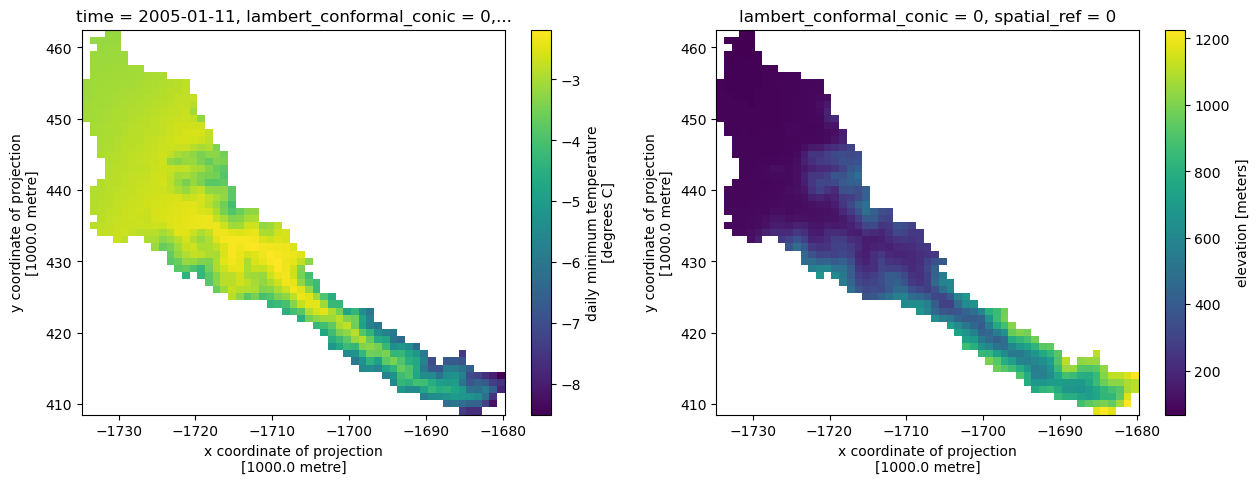

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
clm.tmin.isel(time=10).plot(ax=ax1)
clm.elevation.plot(ax=ax2)